In [7]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath
from mpl_toolkits import mplot3d

In [8]:
# differential equation dm/dt for LLGS (based on debasis' note)" 
def llgs(t, m, H_eff):
    beta = (gamma*hbar*J_mtj)/(2*q_e*M_s*t_mtj) 
    return -(gamma*mu_0)/(1+alpha**2) * np.cross(m, H_eff) \
    - alpha*(gamma*mu_0)/(1+alpha**2) * np.cross(m, np.cross(m,H_eff)) \
    + beta/(1+alpha**2) * np.cross(m, np.cross(m, m_p)) \
    + alpha*beta/(1+alpha**2) * np.cross(m,m_p)

def matCrossify(a):
    return np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
def llgsSmallNoise4(m):
    return -(v_sd*gamma*mu_0)/(1+alpha**2)*np.cross(m, I_sf+alpha*m)

def llgsSmallNoise3(m):
    mCrossified = matCrossify(m)
    return - (v_sd*gamma*mu_0)/(1+alpha**2)* np.matmul(mCrossified, I_sf+alpha*mCrossified)

def llgsSmallNoise2(m):
    return - (v_sd*gamma*mu_0)/(1+alpha**2)*m*I_sf \
    + (v_sd*gamma*mu_0)/(1+alpha**2)*np.cross(m, alpha*m)

def llgsSmallNoise(m):
    mCrossified = matCrossify(m)
    return - (v_sd*gamma*mu_0)/(1+alpha**2)*mCrossified*I_sf \
    + (v_sd*gamma*mu_0)/(1+alpha**2)*np.matmul(mCrossified, alpha*mCrossified)

def llgsRK(x_n, y_n, x, h, H_eff): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * llgs(x_n, y, H_eff) 
        k2 = h * llgs(x_n + 0.5*h, y + 0.5*k1, H_eff) 
        k3 = h * llgs(x_n + 0.5*h, y + 0.5*k2, H_eff) 
        k4 = h * llgs(x_n + h, y + k3, H_eff) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y

def llgsRK4Heun(t_n, m_n, t, h, H_eff):
    m = m_n 
    n = int((t - t_n)/h) # h is time step 
    # Iterate for n number of iterations 
    eta_n = np.sqrt(h)*np.random.normal(0,1)
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of m"
        # LLGS part
        k1 = h * llgs(t_n, m, H_eff) 
        k2 = h * llgs(t_n + 0.5*h, m + 0.5*k1, H_eff) 
        k3 = h * llgs(t_n + 0.5*h, m + 0.5*k2, H_eff) 
        k4 = h * llgs(t_n + h, m + k3, H_eff) 
        # calculate small noise term
        s1 = llgsSmallNoise4(m)
        s2 = llgsSmallNoise4(m + k1*h + s1*eta_n)
        # Update next value of m 
        m = m + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) + (s1 + s2)*eta_n/2
        # Update next value of t 
        t_n = t_n + h 
    print("m shape:"+str(m.shape))
    return m

# calculate m series value of t series
def calcMSeries(t_axis, h, t_0, m_0, noiseFlag=False):
    if noiseFlag:
        # RK4 solution with thermal noise
        m_rk4 = []
        m_prev = m_0
        t_prev = t_0
                
        H_t = v_sd*np.random.normal(0,1)/h #thermal field
        H_eff = [0,0,H_k*m_0[2]] + np.multiply(demag_const, m_0) + H_t
        for t in t_axis:
            print("#################################################################")
            print("step t:"+str(t))
            new_m = llgsRK4Heun(t_prev, m_prev, t, h, H_eff)
            import pdb; pdb.set_trace()
            print("new m:"+str(new_m))
            m_rk4.append(new_m)
            m_prev = new_m
            t_prev = t
            H_t = v_sd*np.random.normal(0,1)/h #thermal field
            H_eff = [0,0,H_k*new_m[2]] + np.multiply(demag_const, new_m) + H_t
            print("new H_eff:"+str(H_eff))
            
    else:
        # RK4 solution without thermal noise
        m_rk4 = []
        m_prev = m_0
        t_prev = t_0

        H_eff = [0,0,H_k*m_0[2]] + np.multiply(demag_const, m_0)  
        for t in t_axis:
            new_m = llgsRK(t_prev, m_prev, t, h, H_eff)
            m_rk4.append(new_m)
            m_prev = new_m
            t_prev = t
            H_eff = [0,0,H_k*new_m[2]] + np.multiply(demag_const, new_m) 
            
        
    # change all elements to list
    for i in range(1,len(m_rk4)):
        m_rk4[i] = m_rk4[i].tolist()
    return m_rk4

# Plots 
def plotM(t_axis, m_list, title):
    # separate mx my mz
    mx = [item[0] for item in m_list]
    my = [item[1] for item in m_list]
    mz = [item[2] for item in m_list]

    # plot result
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.plot(t_axis, mx, '.r-', label='mx')
    plt.plot(t_axis, my, '.g-', label='my')
    plt.plot(t_axis, mz, '.b-', label='mz')

    plt.title(title)
    plt.xlabel("t/s")
    plt.ylabel("mx,my,mz")
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.show()
    # Save figure


In [9]:
###################### Advised constants ######################
alpha = 0.007 #gilbert damping constant
mu_0 = 4*np.pi*(10**(-7)) #(Tm/A)
gamma = 1.76e11 #(rad/sT) gyromagnetic ratio of electron
M_s = 850e3 #(A/m) Saturation magnetization of nanomagnet
# I_s = -0.4644e-3 #(A) applied spin current
delta = 42 #thermal stability factor
temp = 300 #(K) temperature
# hbar = 6.62607015*(10**(-34)) # (J Hz^-1) planck constant from nist
hbar = 1.054e-34          # Reduced Planck's constant (J-s) 
q_e = 1.602176634e-19 # (C) elementary charge of electron from nist
k_b = 1.380649e-23 # (JK^-1) Boltzmann constant from nist
lambda_sf = 1.4e-9 #(m) spin flip length 
theta_she = 0.3 # spinn hall angle 
###################### MTJ dimensions ######################
w_mtj = 40e-9 #(m)
l_mtj = 120e-9 #(m)
t_mtj = 1.5e-9 #(m)
a_mtj = (np.pi/4.0)*l_mtj*w_mtj # cross sectional area of MTJ
v_mtj = a_mtj*t_mtj
###################### SHM1 dimensions ######################
### SHM1 
w_shm1 = 120e-9 #(m)
l_shm1 = 80e-9 #(m)
t_shm1 = 2.8e-9 #(m)
a_shm1 = w_shm1*t_shm1 # (m^2)
P_she1 = (a_mtj/a_shm1)*theta_she*(1-mpmath.sech(t_shm1/lambda_sf))
### SHM2
w_shm2 = 150e-9 #(m)
l_shm2 = 100e-9 #(m)
t_shm2 = 2.8e-9 #(m)
a_shm2 = w_shm2*t_shm2 # (m^2)
P_she2 = (a_mtj/a_shm2)*theta_she*(1-mpmath.sech(t_shm2/lambda_sf))
###################### Thermal field ######################
N_s = 2*M_s*v_mtj/(gamma*hbar) # number of spins
I_sf = q_e*gamma*mu_0*M_s*N_s# scaling factor for spin current 
v_sd = np.sqrt((2*alpha*k_b*temp)/(mu_0*(M_s**2)*v_mtj)) # standard deviation of thermal field
###################### Spin current ######################
I_c = -200e-6 # (A) 
I_s = P_she1*I_c # spin current
H_k = 2*delta*k_b*temp/(v_mtj*mu_0*M_s)
demag_const = np.array([-0.066*M_s, -0.911*M_s, -0.022*M_s])
J_mtj = I_s/a_mtj # surface current for mtj

### Simulating full MTJ

In [10]:
###
t_range = 2*10**(-9)
t_0 = 0
step_amount = 20001
t_axis = np.linspace(t_0,t_range,step_amount)

h = t_range/step_amount
# m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]

In [11]:
########################### Spin current section ###########################
mz0=-0.99
my0=0
mx0=np.sqrt(1-mz0**2)
# mx0=0

m_0 = np.array([mx0, my0, mz0])
m_p = np.array([0,0,1.0])

In [6]:
m_rk4 = calcMSeries(t_axis, h, t_0, m_0)

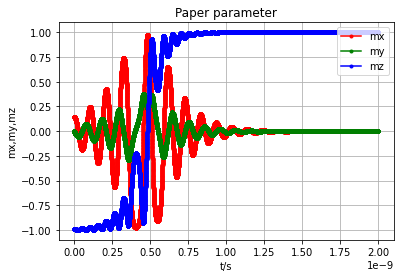

In [8]:
plotM(t_axis, m_rk4, "Paper parameter")

In [ ]:
m_rk4_noise = calcMSeries(t_axis, h, t_0, m_0, True)

#################################################################
step t:0.0
m shape:(3,)
> <ipython-input-8-1934e102d2fe>(82)calcMSeries()
-> print("new m:"+str(new_m))
(Pdb) m[0]
*** NameError: name 'm' is not defined
(Pdb) new_m[0]
0.14106735979665894
(Pdb) new_m
array([ 0.14106736,  0.        , -0.99      ])
(Pdb) type(new_m)
<class 'numpy.ndarray'>
(Pdb) type(new_m[0])
<class 'numpy.float64'>
(Pdb) c
new m:[ 0.14106736  0.         -0.99      ]
new H_eff:[-2.74132375e+10 -2.74132296e+10 -2.74132681e+10]
#################################################################
step t:1e-13
m shape:(3,)
> <ipython-input-8-1934e102d2fe>(81)calcMSeries()
-> import pdb; pdb.set_trace()
(Pdb) tpe(new_m)
*** NameError: name 'tpe' is not defined
(Pdb) new_m
array([mpf('-1.6621211909092041e+24'), mpf('-1.5235840145122658e+24'),
       mpf('-7.3525816684485267e+23')], dtype=object)
(Pdb) type(new_m)
<class 'numpy.ndarray'>
(Pdb) type(new_m[0])
<class 'mpmath.ctx_mp_python.mpf'>


In [ ]:
plotM(t_axis, m_rk4_noise, "Paper parameter noisy")

### params from debasis

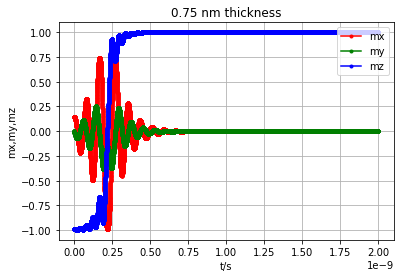

In [47]:
plotM(t_axis, m_rk4, "0.75 nm thickness")

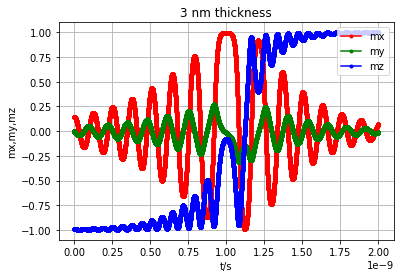

In [21]:
plotM(t_axis, m_rk4, "3 nm thickness")

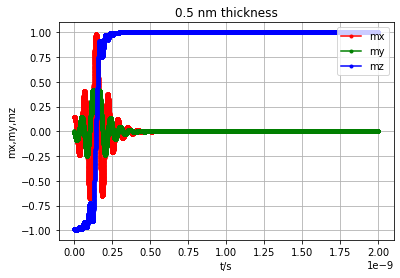

In [29]:
plotM(t_axis, m_rk4, "0.5 nm thickness")

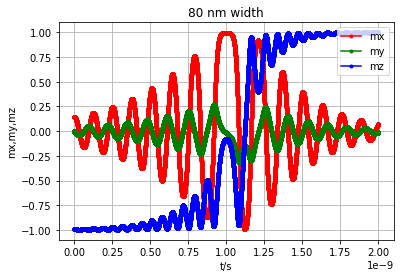

In [35]:
plotM(t_axis, m_rk4, "80 nm width")

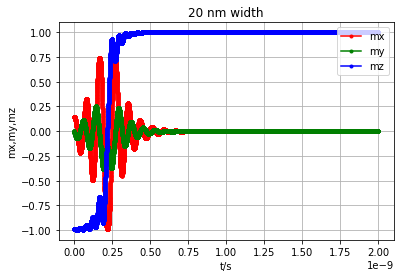

In [41]:
plotM(t_axis, m_rk4, "20 nm width")

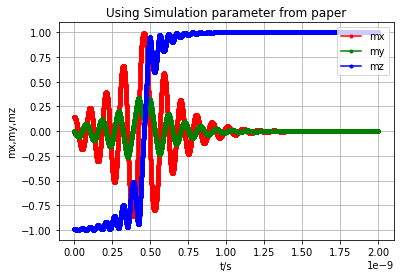

In [31]:
###### Paper parameters
plotM(t_axis, m_rk4)

In [ ]:

x = np.cumsum(np.random.randn(n))